# IMDB_SENTIMENT_ANALYSIS

In [ ]:
colab_notebooks_path = '/content/drive/MyDrive/Colab Notebooks/Sentiment_analysis'
import os

In [ ]:
os.chdir(colab_notebooks_path)

In [ ]:
%pip install contractions
%pip install wordcloud
%pip install nltk
%pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
df.shape

(50000, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


The dataset is already balanced. We will now proceed to data cleaning.

# Data Cleaning

In [ ]:
df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

<ipython-input-19-0554edc9e970>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
df["sentiment"].value_counts()

,count
sentiment,
1,25000
0,25000


In [ ]:
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [ ]:
df['word count'] = df['review'].apply(no_of_words)

In [ ]:
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,1,162
2,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


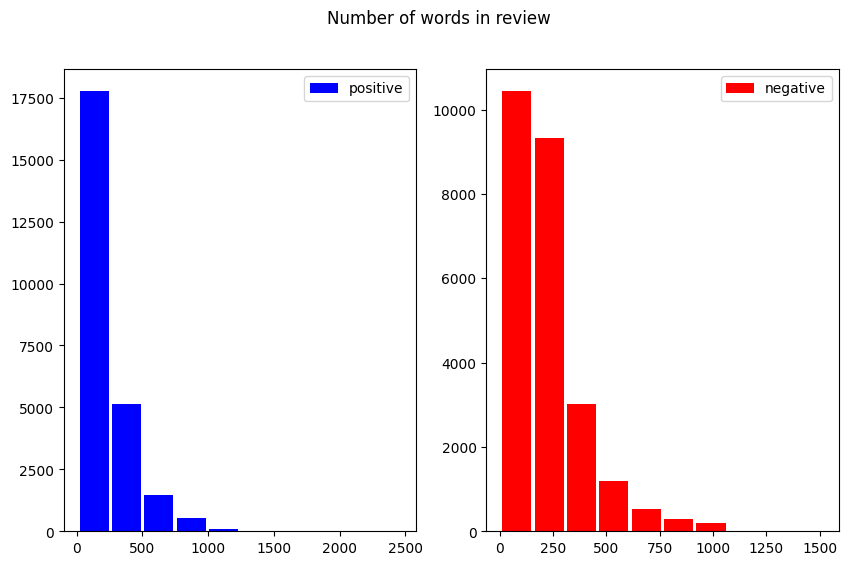

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] ==  1]['word count'], label='positive', color='blue', rwidth=0.9);
ax[0].legend(loc='upper right');
ax[1].hist(df[df['sentiment'] == 0]['word count'], label='negative', color='red', rwidth=0.9);
ax[1].legend(loc='upper right');
fig.suptitle("Number of words in review")
plt.show()

In [ ]:
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  418


In [ ]:
df = df.drop_duplicates('review')

In [ ]:
import nltk
import contractions
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def data_processing(text):
    text = text.lower()  # Convert to lowercase
    text = contractions.fix(text)  # Expand contractions (e.g., "don't" -> "do not")
    text = re.sub(r'<br />', '', text)  # Remove <br /> tags
    text = re.sub(r'https?\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions & hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    # Removes stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['cleaned_review'] = df['review'].apply(data_processing)


In [ ]:
nltk.download('punkt_tab')

def tokenize_text(text):
    return word_tokenize(text)

df['tokenized_review'] = df['cleaned_review'].apply(tokenize_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization to the tokenized review
df['lemmitized_review'] = df['tokenized_review'].apply(lemmatize_tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df.head()

,review,sentiment,word count,cleaned_review,tokenized_review,lemmitized_review
0,One of the other reviewers has mentioned that ...,1,307,one reviewers mentioned watching 1 oz episode ...,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, reviewer, mentioned, watching, 1, oz, ep..."
1,A wonderful little production. <br /><br />The...,1,162,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn...","[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,1,166,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,0,138,basically family little boy jake thinks zombie...,"[basically, family, little, boy, jake, thinks,...","[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,...","[petter, matteis, love, time, money, visually,..."


In [ ]:
df['word count_after'] = df['cleaned_review'].apply(no_of_words)
df.head()

,review,sentiment,word count,cleaned_review,tokenized_review,lemmitized_review,word count_after
0,One of the other reviewers has mentioned that ...,1,307,one reviewers mentioned watching 1 oz episode ...,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, reviewer, mentioned, watching, 1, oz, ep...",163
1,A wonderful little production. <br /><br />The...,1,162,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn...","[wonderful, little, production, filming, techn...",84
2,I thought this was a wonderful way to spend ti...,1,166,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su...",85
3,Basically there's a family where a little boy ...,0,138,basically family little boy jake thinks zombie...,"[basically, family, little, boy, jake, thinks,...","[basically, family, little, boy, jake, think, ...",64
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,...","[petter, matteis, love, time, money, visually,...",125


In [ ]:
pos_reviews =  df[df.sentiment == 1]
neg_reviews = df[df.sentiment == 0]

# Exploratory data analysis

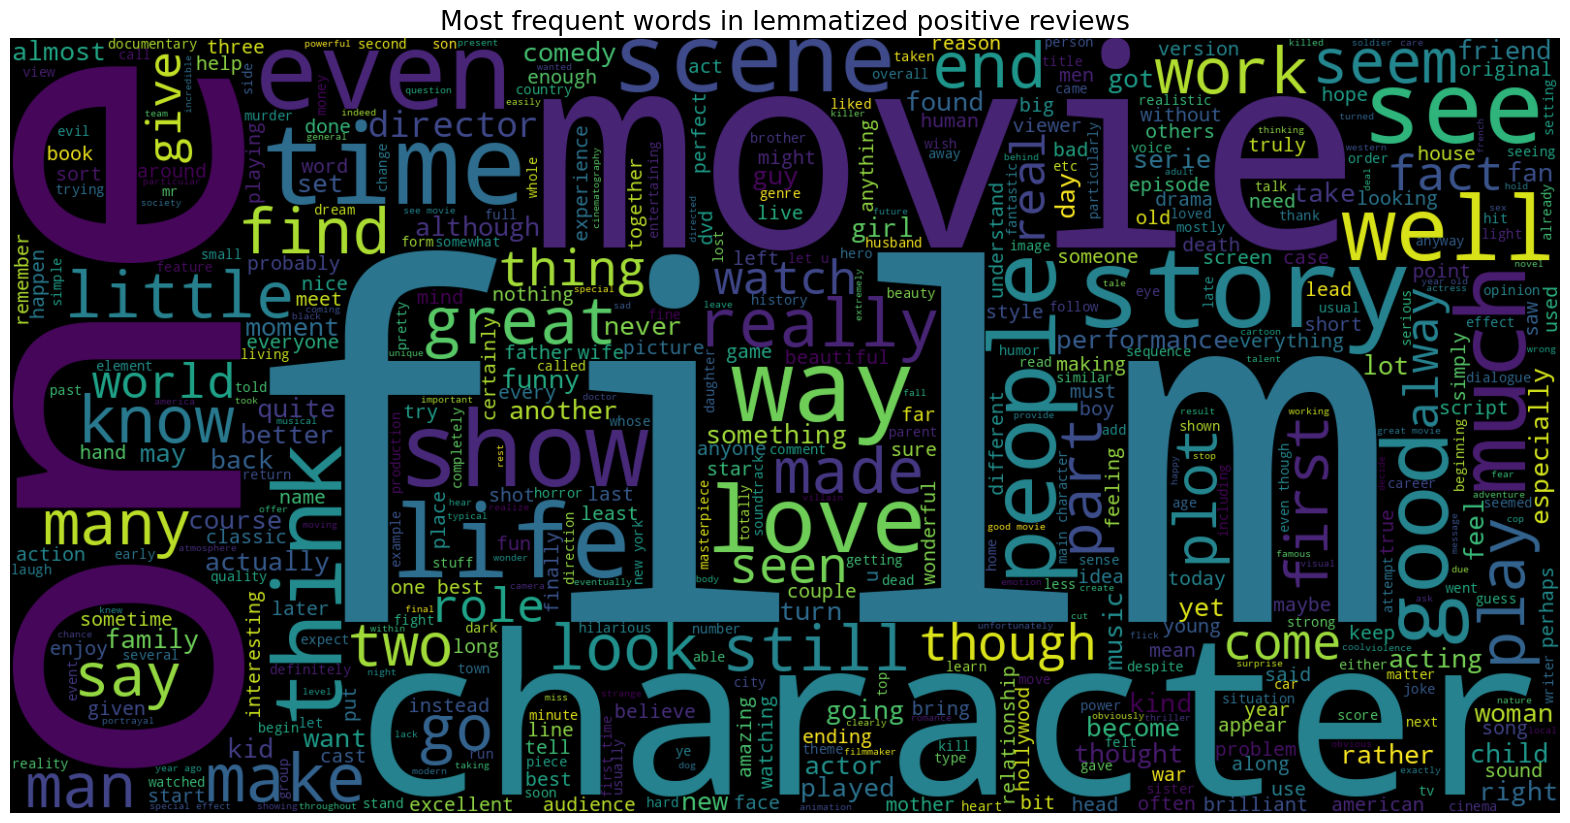

In [ ]:
from wordcloud import WordCloud

# Combine all lemmatized reviews into a single text string
text = ' '.join([' '.join(words) for words in pos_reviews['lemmitized_review']])

# Generate and display the word cloud
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in lemmatized positive reviews', fontsize=19)
plt.show()


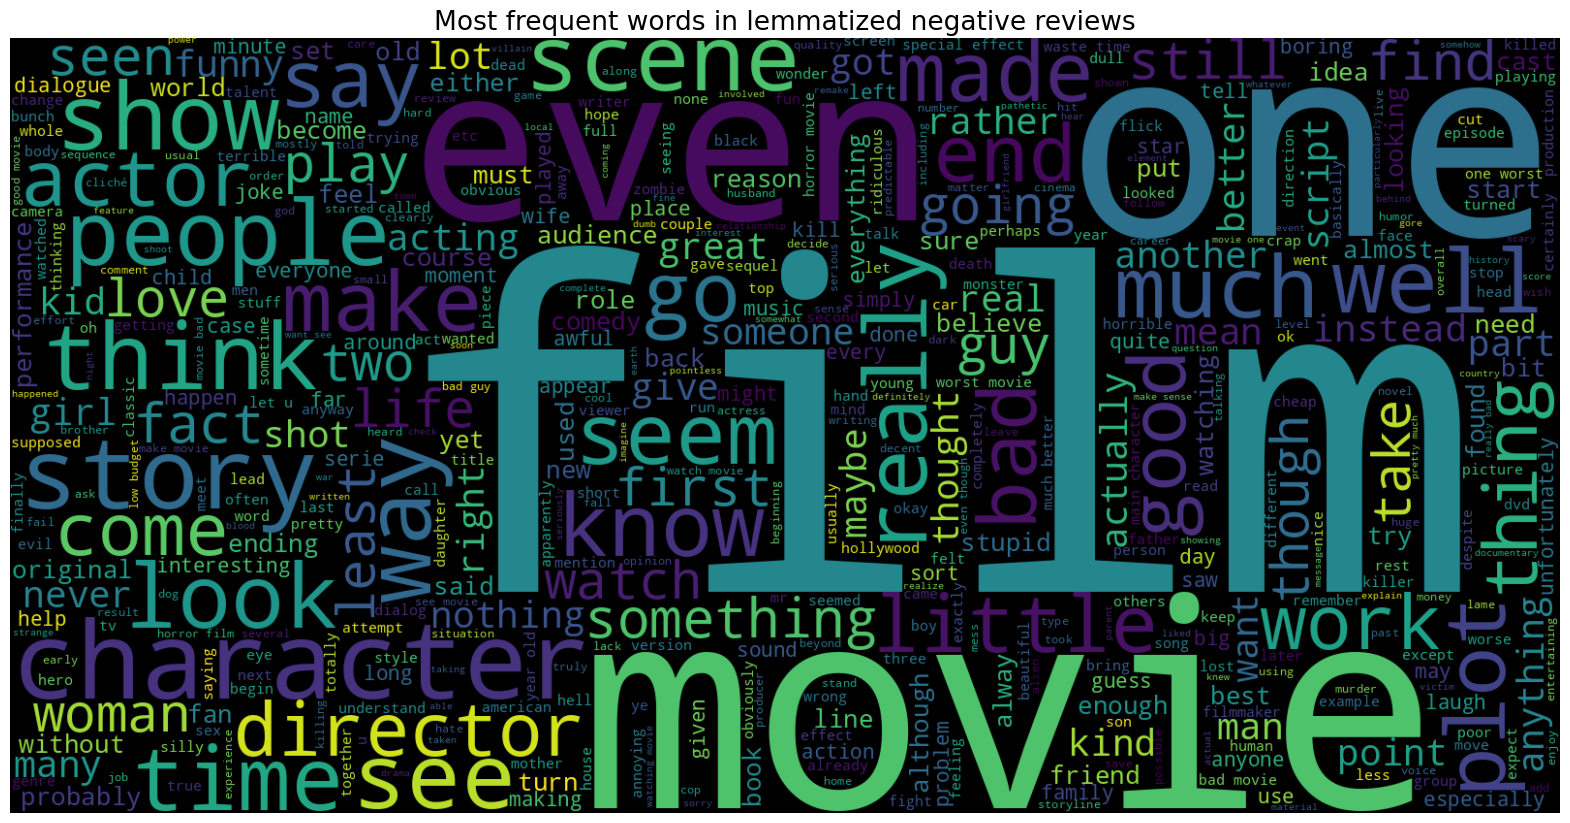

In [ ]:
from wordcloud import WordCloud

# Combine all lemmatized reviews into a single text string
text = ' '.join([' '.join(words) for words in neg_reviews['lemmitized_review']])

# Generate and display the word cloud
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in lemmatized negative reviews', fontsize=19)
plt.show()

In [ ]:
from collections import Counter

count = Counter()
for words in pos_reviews['lemmitized_review'].values:
    count.update(words)

count.most_common(15)

[('film', 47718),
 ('movie', 42897),
 ('one', 26835),
 ('like', 17476),
 ('time', 15116),
 ('good', 14353),
 ('story', 13601),
 ('character', 13565),
 ('would', 13095),
 ('great', 12617),
 ('see', 12478),
 ('get', 11050),
 ('make', 10943),
 ('well', 10936),
 ('really', 10641)]

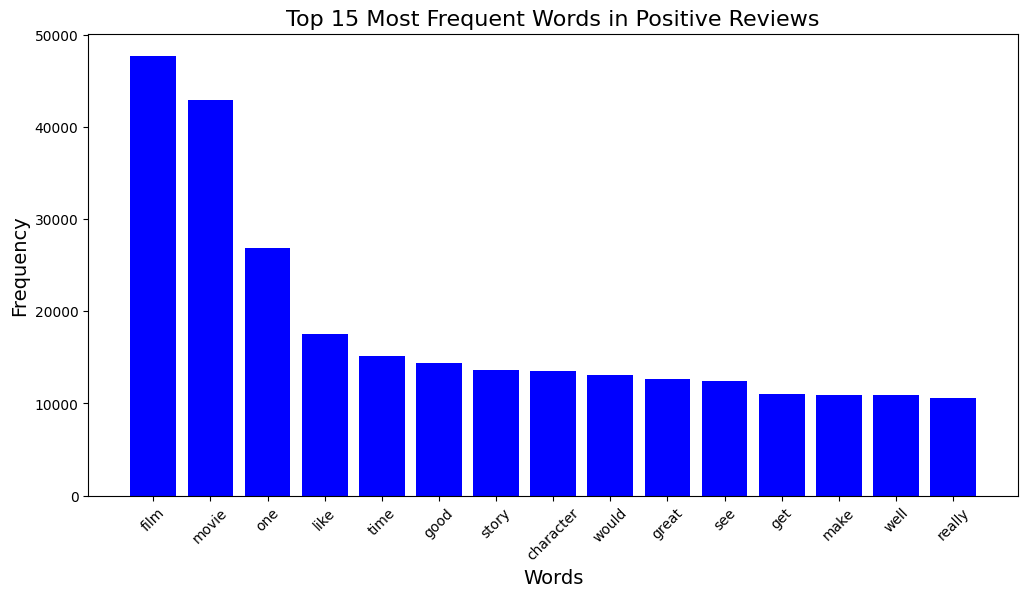

In [ ]:
words, frequencies = zip(*count.most_common(15))

plt.figure(figsize=(12,6))
plt.bar(words, frequencies, color='blue')
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Top 15 Most Frequent Words in Positive Reviews", fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [ ]:
count = Counter()
for words in neg_reviews['lemmitized_review'].values:
    count.update(words)

count.most_common(15)

[('movie', 55295),
 ('film', 41415),
 ('one', 25415),
 ('like', 21972),
 ('would', 17677),
 ('even', 14762),
 ('good', 14041),
 ('time', 13993),
 ('bad', 13906),
 ('character', 13773),
 ('get', 13188),
 ('make', 12465),
 ('really', 12083),
 ('could', 11202),
 ('scene', 10898)]

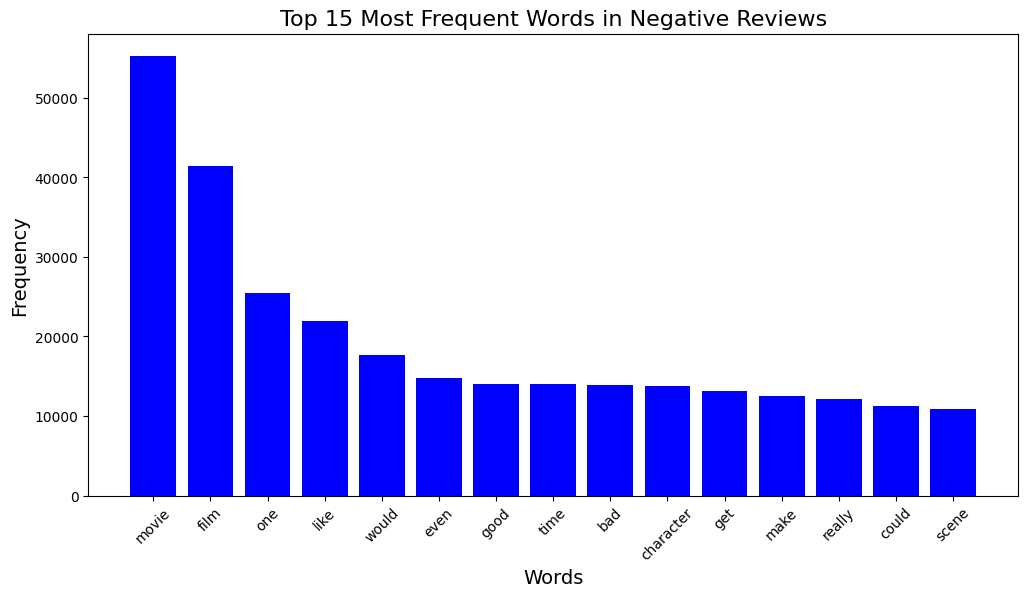

In [ ]:
words, frequencies = zip(*count.most_common(15))

plt.figure(figsize=(12,6))
plt.bar(words, frequencies, color='blue')
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Top 15 Most Frequent Words in Negative Reviews", fontsize=16)
plt.xticks(rotation=45)
plt.show()

# Data Preprocessing
for SVM, Logistic Regression and Naive Bayes

In [ ]:
df.head()

,review,sentiment,word count,cleaned_review,tokenized_review,lemmitized_review,word count_after
0,One of the other reviewers has mentioned that ...,1,307,one reviewers mentioned watching 1 oz episode ...,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, reviewer, mentioned, watching, 1, oz, ep...",163
1,A wonderful little production. <br /><br />The...,1,162,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn...","[wonderful, little, production, filming, techn...",84
2,I thought this was a wonderful way to spend ti...,1,166,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su...",85
3,Basically there's a family where a little boy ...,0,138,basically family little boy jake thinks zombie...,"[basically, family, little, boy, jake, thinks,...","[basically, family, little, boy, jake, think, ...",64
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,...","[petter, matteis, love, time, money, visually,...",125


In [ ]:
X = df['review']
Y = df['sentiment']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
X_train_cleaned = x_train.apply(data_processing)
X_test_cleaned = x_test.apply(data_processing)

# Tokenization
X_train_tokenized = X_train_cleaned.apply(tokenize_text)
X_test_tokenized = X_test_cleaned.apply(tokenize_text)

# Lemmatization
X_train_lemmatized = X_train_tokenized.apply(lemmatize_tokens)
X_test_lemmatized = X_test_tokenized.apply(lemmatize_tokens)

In [ ]:
X_train_text = X_train_lemmatized.apply(lambda words: ' '.join(words))
X_test_text = X_test_lemmatized.apply(lambda words: ' '.join(words))

tfidf = TfidfVectorizer()

# Fit and transform on training data, transform on test data
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)


# Model training
for SVM, Logistic Regression and Naive Bayes

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train)
logreg_pred = logreg.predict(X_test_tfidf)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: Logistic_Regression {:.2f}%".format(logreg_acc*100))
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))


mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
mnb_pred = mnb.predict(X_test_tfidf)
mnb_acc = accuracy_score(mnb_pred, y_test)
print("Test accuracy: Naive_Baiyes {:.2f}%".format(mnb_acc*100))
print(confusion_matrix(y_test, mnb_pred))
print("\n")
print(classification_report(y_test, mnb_pred))

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
svm_pred = svm.predict(X_test_tfidf)
svm_acc = accuracy_score(svm_pred, y_test)
print("Test accuracy: SVM {:.2f}%".format(svm_acc*100))
print(confusion_matrix(y_test, svm_pred))
print("\n")
print(classification_report(y_test, svm_pred))

Test accuracy: Logistic_Regression 89.24%
[[6504  900]
 [ 701 6770]]


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7404
           1       0.88      0.91      0.89      7471

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875

Test accuracy: Naive_Baiyes 86.53%
[[6442  962]
 [1042 6429]]


              precision    recall  f1-score   support

           0       0.86      0.87      0.87      7404
           1       0.87      0.86      0.87      7471

    accuracy                           0.87     14875
   macro avg       0.87      0.87      0.87     14875
weighted avg       0.87      0.87      0.87     14875

Test accuracy: SVM 89.50%
[[6561  843]
 [ 719 6752]]


              precision    recall  f1-score   support

           0       0.90      0.89      0.89      7404
           1       0.89      0.90      0.90    

SVM performed slightly better than Logistic Regression

In [ ]:
# Model Instantiation
logreg = LogisticRegression(solver='liblinear') #added solver to remove warnings
mnb = MultinomialNB()
svm = LinearSVC()

# Parameter Grids
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']}

nb_param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]}

svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],}

# Logistic Regression
grid_logreg = GridSearchCV(logreg, logreg_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_logreg.fit(X_train_tfidf, y_train)
print("Best parameters for Logistic Regression:", grid_logreg.best_params_)
logreg_pred = grid_logreg.best_estimator_.predict(X_test_tfidf)
logreg_acc = accuracy_score(y_test, logreg_pred)
print("\nAccuracy: {:.2f}%".format(logreg_acc * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, logreg_pred))
print("\nClassification Report:\n", classification_report(y_test, logreg_pred))


# Naive Bayes
grid_nb = GridSearchCV(mnb, nb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_nb.fit(X_train_tfidf, y_train)
print("Best parameters for Naïve Bayes:", grid_nb.best_params_)
nb_best = grid_nb.best_estimator_
nb_pred = nb_best.predict(X_test_tfidf)
nb_acc = accuracy_score(y_test, nb_pred)
print("\nTest Accuracy: {:.2f}%".format(nb_acc * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, nb_pred))
print("\nClassification Report:\n", classification_report(y_test, nb_pred))

# SVM
grid_svm = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_tfidf, y_train)
print("Best parameters for SVM:", grid_svm.best_params_)
svm_pred = grid_svm.best_estimator_.predict(X_test_tfidf)
svm_acc = accuracy_score(y_test, svm_pred)
print("\nSVM Accuracy: {:.2f}%".format(svm_acc * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, svm_pred))
print("\nClassification Report:\n", classification_report(y_test, svm_pred))



Best parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}

Accuracy: 89.45%

Confusion Matrix:
 [[6552  852]
 [ 717 6754]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      7404
           1       0.89      0.90      0.90      7471

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875

Best parameters for Naïve Bayes: {'alpha': 1}

Test Accuracy: 86.53%

Confusion Matrix:
 [[6442  962]
 [1042 6429]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      7404
           1       0.87      0.86      0.87      7471

    accuracy                           0.87     14875
   macro avg       0.87      0.87      0.87     14875
weighted avg       0.87      0.87      0.87     14875

Best parameters for SVM: {'C': 0.1}

SVM Accu

Not much difference after hyperparameter tuning

Now, we make our deep learning LSTM (Long short term memory )

MODEL TRAINING
for **LSTM**

In [ ]:
def data_processing_LSTM(text):
    text = text.lower()  # Convert to lowercase
    text = contractions.fix(text)  # Expand contractions (e.g., "don't" -> "do not")
    text = re.sub(r'<br />', '', text)  # Remove <br /> tags
    text = re.sub(r'https?\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions (but keep hashtags)

    # Keep punctuation that conveys emotion (!, ?, .) and hashtags
    text = re.sub(r'[^a-zA-Z0-9#?!.,\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    return text


In [ ]:
X_train = x_train.apply(data_processing_LSTM)
X_test = x_test.apply(data_processing_LSTM)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train2 = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200)
X_test2 = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200)

In [ ]:
print(X_train2)

[[  24   13  146 ...    6   98   45]
 [   0    0    0 ...    6  157   45]
 [   0    0    0 ...   29    1  786]
 ...
 [ 127    2   92 ...    7    3 2427]
 [   0    0    0 ...  229  104  122]
 [   0    0    0 ...    4    1 2679]]


In [ ]:
print(X_test2)

[[   0    0    0 ...   39  844 3421]
 [   3 1294    2 ...   36   10   27]
 [ 406 4155    1 ...    1   40    1]
 ...
 [ 108  149    9 ...  128   14   73]
 [   0    0    0 ...   11 4751  263]
 [   0    0    0 ...   39  255   12]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import tensorflow as tf

# Define hyperparameters
vocab_size = 5000       # Size of the vocabulary
embedding_dim = 128     # Dimension of word embeddings
max_length = 200       # Maximum length of sequences


model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation="sigmoid")
])

model(tf.keras.Input(shape=(max_length,)))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(X_train2, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 316s 717ms/step - accuracy: 0.7391 - loss: 0.5177 - val_accuracy: 0.8513 - val_loss: 0.3706
Epoch 2/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 323s 720ms/step - accuracy: 0.8643 - loss: 0.3364 - val_accuracy: 0.8283 - val_loss: 0.3856
Epoch 3/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 317s 708ms/step - accuracy: 0.8766 - loss: 0.3039 - val_accuracy: 0.8515 - val_loss: 0.3494
Epoch 4/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 326s 718ms/step - accuracy: 0.8966 - loss: 0.2609 - val_accuracy: 0.8702 - val_loss: 0.3345
Epoch 5/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 317s 730ms/step - accuracy: 0.9103 - loss: 0.2211 - val_accuracy: 0.8744 - val_loss: 0.3245


In [ ]:
loss, accuracy = model.evaluate(X_test2, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

465/465 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.8712 - loss: 0.3205
465/465 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.8712 - loss: 0.3205
Test Loss: 0.32619181275367737
Test Accuracy: 0.872201681137085
Test Loss: 0.32619181275367737
Test Accuracy: 0.872201681137085


Out of all the models, logistic regression was the most accurate. We will now make a predictive system using both logistic regression and LSTM

# Predictive system

In [ ]:
import joblib
joblib.dump(grid_logreg.best_estimator_, 'logistic_regression_model.pkl')
joblib.dump(data_processing, 'data_processing.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

In [ ]:
# Loading the saved components
data_processing = joblib.load('data_processing.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
logreg_model = joblib.load('logistic_regression_model.pkl')

def predict_sentiment(review):
    processed_review = data_processing(review)  # Apply preprocessing
    transformed_review = tfidf_vectorizer.transform([processed_review])  # Transform using TF-IDF
    prediction = logreg_model.predict(transformed_review)
    return "Positive" if prediction[0] == 1 else "Negative"

In [ ]:
## Easy positive cases
review1 = "Absolutely loved this movie! The storyline was engaging, and the performances were top-notch."
review2 = "An excellent film with brilliant acting and a captivating script. Definitely worth watching!"
review3 = "One of the best movies I’ve seen in a long time! The cinematography was breathtaking."
review4 = "The book was a masterpiece. Every page kept me hooked, and I couldn’t put it down!"
review5 = "Fantastic customer service! They went above and beyond to help me with my issue."
review6 = "I had an amazing experience at this restaurant. The food was delicious, and the ambiance was perfect!"
reviews = [review1, review2, review3, review4, review5, review6]

for i, review in enumerate(reviews, 1):
    prediction = predict_sentiment(review)
    print(f"Review {i}: {prediction}")


Review 1: Positive
Review 2: Positive
Review 3: Positive
Review 4: Positive
Review 5: Positive
Review 6: Positive


In [ ]:
## Tough positive cases
review1 = "Despite a slow start, this turned out to be an incredibly rewarding experience!"
review2 = "I was skeptical at first, but this completely exceeded my expectations in the best way possible."
review3 = "The level of detail and craftsmanship is simply astonishing—truly a work of art!"
review4 = "It may not be for everyone, but for those who appreciate depth and nuance, this is a masterpiece."
review5 = "At first, I wasn't sure how I felt, but the more I thought about it, the more I realized how brilliant it was."
review6 = "Subtle, yet powerful. The emotions linger long after the experience is over."
review7 = "A hidden gem! You don’t realize how great it is until you take the time to appreciate the little details."
review8 = "Even with minor flaws, the sheer effort and passion behind this make it a standout success."
review9 = "Not perfect, but its strengths far outweigh its weaknesses. I can't recommend it enough!"
review10 = "A slow burn that pays off in the most beautiful way—patience is rewarded here!"
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10]

for i, review in enumerate(reviews, 1):
    prediction = predict_sentiment(review)
    print(f"Review {i}: {prediction}")

Review 1: Negative
Review 2: Positive
Review 3: Positive
Review 4: Positive
Review 5: Positive
Review 6: Positive
Review 7: Positive
Review 8: Negative
Review 9: Positive
Review 10: Positive


In [ ]:
## Easy negative cases
review1 = "This was a complete waste of time."
review2 = "I really regret spending money on this."
review3 = "It was so boring, I couldn't even finish it."
review4 = "Terrible experience, would not recommend."
review5 = "Everything about this was disappointing."
review6 = "I expected much better, but this was awful."
review7 = "The worst I’ve seen in a long time."
reviews = [review1, review2, review3, review4, review5, review6, review7]

for i, review in enumerate(reviews, 1):
    prediction = predict_sentiment(review)
    print(f"Review {i}: {prediction}")


Review 1: Negative
Review 2: Negative
Review 3: Negative
Review 4: Negative
Review 5: Negative
Review 6: Negative
Review 7: Negative


In [ ]:
## Tough negative cases
review1 = "Oh great, another software update that slows everything down. Just what I needed!"
review2 = "Wow, that movie was an absolute masterpiece... if you enjoy watching paint dry."
review3 = "I appreciate the effort, but this is the worst experience I've had with customer support."
review4 = "Thank you for trying, but the product simply does not work as advertised."
review5 = "I am absolutely amazed at how bad this service is. Truly groundbreaking!"
review6 = "If you love wasting money, this is the perfect purchase for you!"
review7 = "I cried so much watching this movie... because I spent money on it."
review8 = "I can’t believe how much I regret this decision. It seemed good at first."
reviews = [review1, review2, review3, review4, review5, review6, review7, review8]

for i, review in enumerate(reviews, 1):
    prediction = predict_sentiment(review)
    print(f"Review {i}: {prediction}")


Review 1: Negative
Review 2: Negative
Review 3: Negative
Review 4: Negative
Review 5: Negative
Review 6: Positive
Review 7: Negative
Review 8: Negative


Predictive system for LSTM

In [ ]:
def predict_sentiment_LSTM(review):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment

In [ ]:
## Tough positive cases
review1 = "Despite a slow start, this turned out to be an incredibly rewarding experience!"
review2 = "I was skeptical at first, but this completely exceeded my expectations in the best way possible."
review3 = "The level of detail and craftsmanship is simply astonishing—truly a work of art!"
review4 = "It may not be for everyone, but for those who appreciate depth and nuance, this is a masterpiece."
review5 = "At first, I wasn't sure how I felt, but the more I thought about it, the more I realized how brilliant it was."
review6 = "Subtle, yet powerful. The emotions linger long after the experience is over."
review7 = "A hidden gem! You don’t realize how great it is until you take the time to appreciate the little details."
review8 = "Even with minor flaws, the sheer effort and passion behind this make it a standout success."
review9 = "Not perfect, but its strengths far outweigh its weaknesses. I can't recommend it enough!"
review10 = "A slow burn that pays off in the most beautiful way—patience is rewarded here!"
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10]

for i, review in enumerate(reviews, 1):
    prediction = predict_sentiment_LSTM(review)
    print(f"Review {i}: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Review 1: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Review 2: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Review 3: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Review 4: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Review 5: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Review 6: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Review 7: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Review 8: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Review 9: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Review 10: negative


In [ ]:
## Tough negative cases
review1 = "Oh great, another software update that slows everything down. Just what I needed!"
review2 = "Wow, that movie was an absolute masterpiece... if you enjoy watching paint dry."
review3 = "I appreciate the effort, but this is the worst experience I've had with customer support."
review4 = "Thank you for trying, but the product simply does not work as advertised."
review5 = "I am absolutely amazed at how bad this service is. Truly groundbreaking!"
review6 = "If you love wasting money, this is the perfect purchase for you!"
review7 = "I cried so much watching this movie... because I spent money on it."
review8 = "I can’t believe how much I regret this decision. It seemed good at first."
reviews = [review1, review2, review3, review4, review5, review6, review7, review8]

for i, review in enumerate(reviews, 1):
    prediction = predict_sentiment_LSTM(review)
    print(f"Review {i}: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Review 1: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Review 2: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Review 3: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Review 4: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Review 5: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Review 6: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Review 7: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Review 8: positive
